In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../lib/exlib/src')
from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [3]:
# model paths
# backbone_model_name = 'google/vit-base-patch16-224'
backbone_model_name = '../pt_models/vit-base-patch16-224-imagenet10cls'
backbone_processor_name = 'google/vit-base-patch16-224'
# sop_config_path = 'configs/imagenet_m.json'

# data paths
TRAIN_DATA_DIR = '../data/imagenet_m/train'
VAL_DATA_DIR = '../data/imagenet_m/val'

# training args
batch_size = 1
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
# exp_dir = '../exps/imagenet_2h_10/best'
exp_dir = '../exps/imagenet_m_2h/best'

In [4]:
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

config = SOPConfig()
config.update_from_json(os.path.join(exp_dir, 'config.json'))

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class ImageFolderSubDataset(Dataset):
    def __init__(self, data_dir, transform=None, num_data=-1):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in sorted(os.listdir(data_dir)):
            dirname = os.path.join(data_dir, label)
            if not os.path.isdir(dirname):
                continue
            for i, image_path in enumerate(sorted(os.listdir(dirname))):
                if num_data != -1 and i >= num_data:
                    break
                self.image_paths.append(os.path.join(data_dir, label, image_path))
                self.labels.append(label)
        self.all_labels = sorted(list(set(self.labels)))
        
        print('Loaded {} images and {} classes'.format(len(self.image_paths), len(self.all_labels))) 
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.all_labels.index(self.labels[idx])
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# Load the dataset
# train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
# val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)
# num_data = 10
num_data = -1
train_dataset = ImageFolderSubDataset(TRAIN_DATA_DIR, transform=transform, num_data=num_data)
val_dataset = ImageFolderSubDataset(VAL_DATA_DIR, transform=transform, num_data=num_data)

# Use subset for testing purpose
# num_data = 100
# train_dataset = Subset(train_dataset, range(num_data))
# val_dataset = Subset(val_dataset, range(num_data))

# Create a DataLoader to batch and shuffle the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loaded 13000 images and 10 classes
Loaded 500 images and 10 classes


In [7]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])

In [8]:
wrapped_backbone_model = WrappedBackboneModel(backbone_model)
wrapped_backbone_model = wrapped_backbone_model.to(device)
class_weights = get_chained_attr(wrapped_backbone_model, config.finetune_layers[0]).weight #.clone().to(device)

In [9]:
model = SOPImageCls(config, wrapped_backbone_model, class_weights=class_weights, projection_layer=None)
state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth'))
model.load_state_dict(state_dict['model'])
model = model.to(device)
model.eval();

deep copy class weights


In [10]:
model.class_weights

Parameter containing:
tensor([[-2.0094e-02,  3.1304e-02, -1.8383e-02,  ..., -1.2401e-02,
          4.7422e-02, -2.6157e-03],
        [-4.1206e-02, -2.0249e-04,  6.2646e-03,  ...,  2.0670e-02,
          1.9803e-02, -9.0481e-03],
        [-5.1546e-02,  4.5810e-02, -2.6370e-03,  ..., -4.0991e-02,
          2.7189e-02,  3.9951e-03],
        ...,
        [ 3.2672e-03, -4.9546e-02,  3.9129e-03,  ...,  2.7700e-02,
         -1.2544e-02,  1.1275e-02],
        [-4.2260e-03, -6.8635e-02,  3.3225e-05,  ...,  3.5973e-02,
         -1.5489e-03,  2.0367e-02],
        [-1.1041e-02,  9.5179e-03, -8.6945e-03,  ...,  2.7127e-02,
          2.9737e-03, -2.1733e-02]], device='cuda:0', requires_grad=True)

In [85]:
# batch = list(iter(val_dataloader))[1]
for b_i, batch in enumerate(val_dataloader):
    if b_i == 1:
        break
inputs, labels = batch
inputs, labels = inputs.to(device), labels.to(device)

In [86]:
with torch.no_grad():
    expln = model(inputs, return_tuple=True)

In [87]:
expln.attributions.shape

torch.Size([1, 1, 224, 224])

In [88]:
denormed_img = (inputs[0:1] + 1) / 2

## Aggregate Prediction Consistency

In [23]:
expln.masks.shape, expln.mask_weights.shape, expln.logits.shape, expln.logits_all.shape, expln.grouped_attributions.shape

(torch.Size([1, 392, 224, 224]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 392, 10]))

In [24]:
(expln.grouped_attributions.sum(dim=-2) - expln.logits)[:,:10], (expln.grouped_attributions.sum(dim=-2) - expln.logits).shape

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5367e-07,
           0.0000e+00,  4.7684e-07,  0.0000e+00,  0.0000e+00, -7.4506e-09]],
        device='cuda:0'),
 torch.Size([1, 10]))

In [25]:
expln.grouped_attributions.sum(dim=-2)[:,:10], expln.grouped_attributions.sum(dim=-2).shape

(tensor([[11.8028,  5.9782,  8.9899,  9.7002,  9.2918,  4.5400,  6.5249,  0.3107,
          -0.0616,  0.0679]], device='cuda:0'),
 torch.Size([1, 10]))

In [26]:
expln.logits[:,:10]

tensor([[11.8028,  5.9782,  8.9899,  9.7002,  9.2918,  4.5400,  6.5249,  0.3107,
         -0.0616,  0.0679]], device='cuda:0')

In [27]:
attrs = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs.shape

torch.Size([1, 10, 224, 224])

In [28]:
attrs[0][labels].cpu().numpy()[0]

array([[0.9665046 , 0.9665046 , 0.9665046 , ..., 0.98412764, 0.98412764,
        0.98412764],
       [0.9665046 , 0.9665046 , 0.9665046 , ..., 0.98412764, 0.98412764,
        0.98412764],
       [0.9665046 , 0.9665046 , 0.9665046 , ..., 0.98412764, 0.98412764,
        0.98412764],
       ...,
       [0.72512764, 0.72512764, 0.72512764, ..., 0.9342228 , 0.9342228 ,
        0.9342228 ],
       [0.72512764, 0.72512764, 0.72512764, ..., 0.9342228 , 0.9342228 ,
        0.9342228 ],
       [0.72512764, 0.72512764, 0.72512764, ..., 0.9342228 , 0.9342228 ,
        0.9342228 ]], dtype=float32)

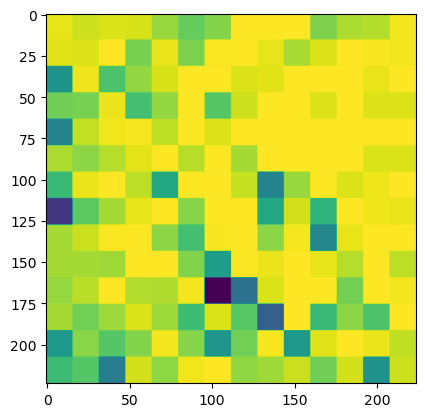

In [29]:
import matplotlib.pyplot as plt
plt.imshow(attrs[0][labels].cpu().numpy()[0])

In [30]:
attrs2 = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1) * expln.logits_all.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs2.shape

torch.Size([1, 10, 224, 224])

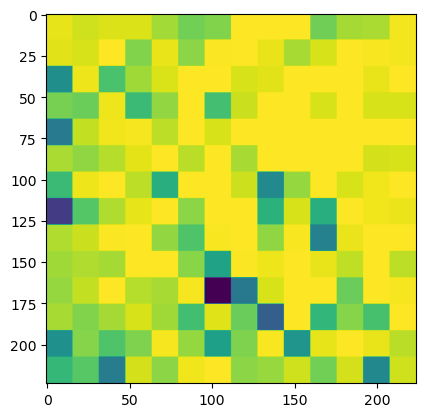

In [31]:
import matplotlib.pyplot as plt
plt.imshow(attrs2[0][labels].cpu().numpy()[0])

## Insertion Deletion

In [32]:
from exlib.evaluators.ins_del import InsertionCls, DeletionCls

 99%|█████████▉| 223/225 [03:57<00:02,  1.07s/it]


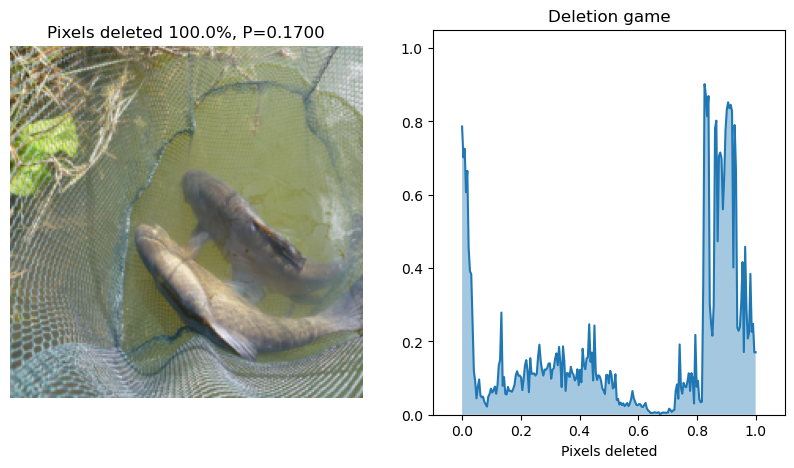

tensor([0.1784], device='cuda:0')


In [33]:
del_evaluator = DeletionCls(model)
with torch.no_grad():
    del_eval_output = del_evaluator(inputs, expln.attributions, return_dict=True)
del_scores = del_eval_output['scores']
del_evaluator.plot(denormed_img[0], del_scores[0])
print(del_eval_output['auc_score'])

In [ ]:
ins_evaluator = InsertionCls(model)
with torch.no_grad():
    ins_eval_output = ins_evaluator(inputs, expln.attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])

In [30]:
ins_eval_output['auc_score']

tensor([0.0862], device='cuda:0')

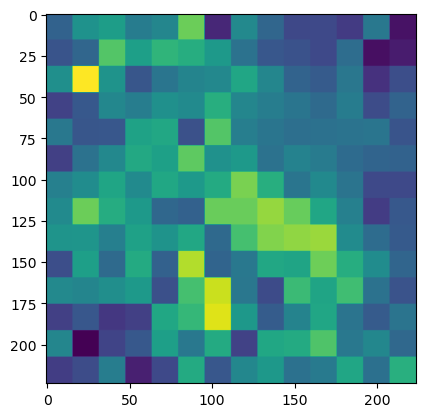

In [31]:
import matplotlib.pyplot as plt
plt.imshow(expln.attributions[0][0].cpu().numpy())

In [32]:
for i in range(expln.attributions_all.shape[1]):
    plt.figure()
    plt.imshow(expln.attributions_all[0][i].cpu().numpy())
    plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [33]:
from exlib.evaluators.ins_del import GroupedInsertionCls, GroupedDeletionCls

In [34]:
gdel_evaluator = GroupedDeletionCls(model)
with torch.no_grad():
    gdel_score = gdel_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gdel_score)

tensor([0.1399], device='cuda:0')


In [35]:
with torch.no_grad():
    gdel_eval_output = gdel_evaluator(inputs, expln.attributions[0], expln.flat_masks, return_dict=True)

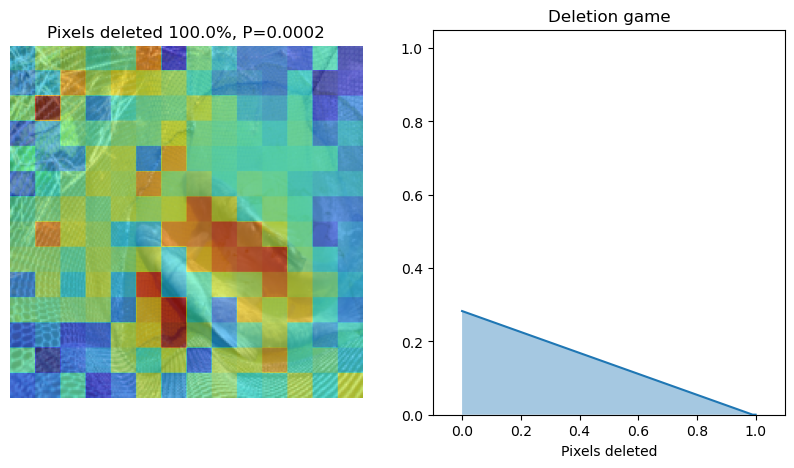

In [36]:
gdel_evaluator.plot(denormed_img[0], expln.attributions[0], gdel_eval_output['scores'][0], gdel_eval_output['step_sizes'][0])

In [37]:
gins_evaluator = GroupedInsertionCls(model)
with torch.no_grad():
    gins_score = gins_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gins_score)

tensor([0.0016], device='cuda:0')


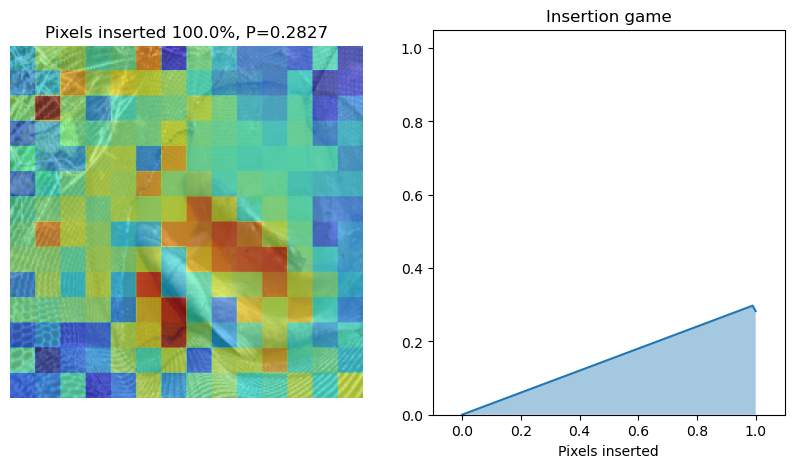

In [38]:
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, expln.attributions, expln.flat_masks, return_dict=True)
gins_evaluator.plot(denormed_img[0], expln.attributions[0], gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])

In [39]:
gins_eval_output['scores']

[tensor([1.5233e-04, 2.9744e-01, 2.8272e-01], device='cuda:0')]

## Baselines

### Archipelago

In [40]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pickle

sys.path.append("../lib/archipelago/src")
from explainer import Archipelago
from application_utils.image_utils import *
from application_utils.utils_torch import ModelWrapperTorch

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [41]:
explanation_outline_thickness = 1

In [42]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [43]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)
wrapped_backbone_model_raw = wrapped_backbone_model_raw.to(device)
model_wrapper = ModelWrapperTorch(wrapped_backbone_model_raw, device)

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


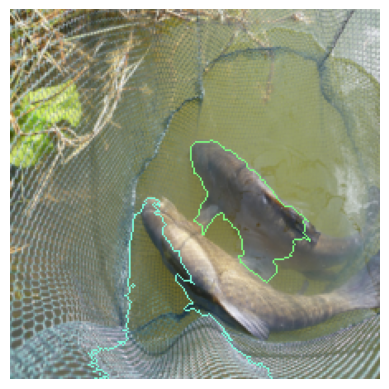

In [44]:
top_k = 5

# results = []
# for index in tqdm(indexes[:12+len(skip_imgs)]):    
# if index in skip_imgs: continue

# image_path = test_data[index]
# img_filename = image_path.split("/")[-1]
# image, labels = get_image_and_labels(image_path, device)

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()
    
    # results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [45]:
explanation

{(0,): 0.36631235,
 (1,): 1.2256683,
 (2,): 0.87825423,
 (3,): -0.10991482,
 (4,): 0.49068063,
 (5,): 0.9171949,
 (6,): 0.28107288,
 (7,): 0.41432568,
 (8,): 1.600123,
 (9,): 0.25353518,
 (10,): 0.52417314,
 (11,): 0.3632599,
 (12,): 0.6516536,
 (13,): 0.7369871,
 (14,): 0.4035882,
 (15,): -0.66210943,
 (16,): -0.047267713,
 (17,): 0.52677643,
 (18,): -0.5767415,
 (19,): -0.77188706,
 (20,): 0.29864955,
 (21,): 0.24233347,
 (22,): -0.8234837,
 (23, 27): 8.61786,
 (24,): 1.1737636,
 (25,): 0.030279893,
 (26,): 0.97367144,
 (28, 39, 40, 43, 46): 0.8435415,
 (29,): 0.52370656,
 (30,): 2.8222198,
 (31,): -0.5935525,
 (32,): 0.11827709,
 (33,): -0.37499,
 (34,): -0.5429117,
 (35,): 4.227139,
 (36,): 1.3922184,
 (37,): -0.029974595,
 (38,): 0.12987338,
 (41,): 0.58167034,
 (42,): 1.8296357,
 (44,): 0.5488981,
 (45,): 0.6872907}

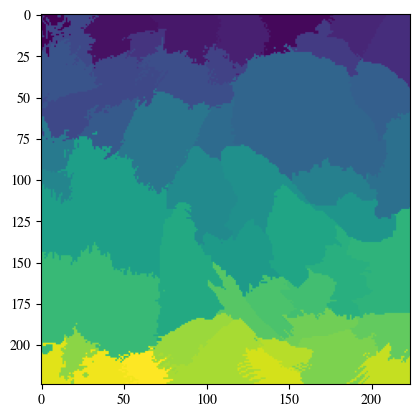

In [46]:
plt.imshow(segments)

In [47]:
segments.shape

(224, 224)

torch.Size([1, 224, 224])


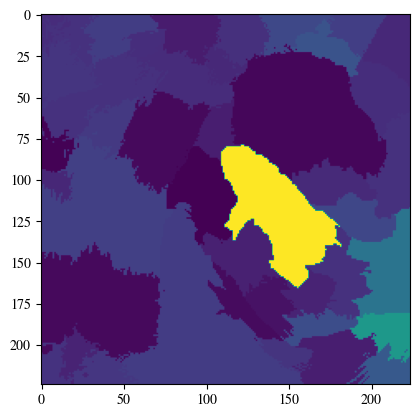

In [48]:
expln_scores = np.zeros_like(segments, dtype=float)
expln_flat_masks = np.zeros_like(segments, dtype=float)

for e_i, (k, v) in enumerate(explanation.items()):
    for s_i in k:
        expln_scores[segments == s_i] = v
        expln_flat_masks[segments == s_i] = e_i
plt.imshow(expln_scores)
expln_flat_masks = torch.tensor(expln_flat_masks).unsqueeze(0).to(device)
print(expln_flat_masks.shape)

In [49]:
expln_scores

array([[0.36631235, 0.36631235, 0.36631235, ..., 0.28107288, 0.28107288,
        0.28107288],
       [0.36631235, 0.52417314, 0.36631235, ..., 0.28107288, 0.28107288,
        0.28107288],
       [0.52417314, 0.36631235, 0.36631235, ..., 0.28107288, 0.28107288,
        0.28107288],
       ...,
       [0.5488981 , 0.5488981 , 0.5488981 , ..., 1.82963574, 1.82963574,
        1.82963574],
       [0.5488981 , 0.5488981 , 0.5488981 , ..., 1.82963574, 1.82963574,
        1.82963574],
       [0.5488981 , 0.5488981 , 0.5488981 , ..., 1.82963574, 1.82963574,
        1.82963574]])

In [50]:
from collections import namedtuple


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [51]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)

expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)

del_evaluator_bbm = DeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    del_score_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor)
del_score_archipelago

 99%|█████████▉| 223/225 [00:01<00:00, 149.37it/s]


tensor([0.0647], device='cuda:0')

 99%|█████████▉| 223/225 [00:01<00:00, 163.78it/s]


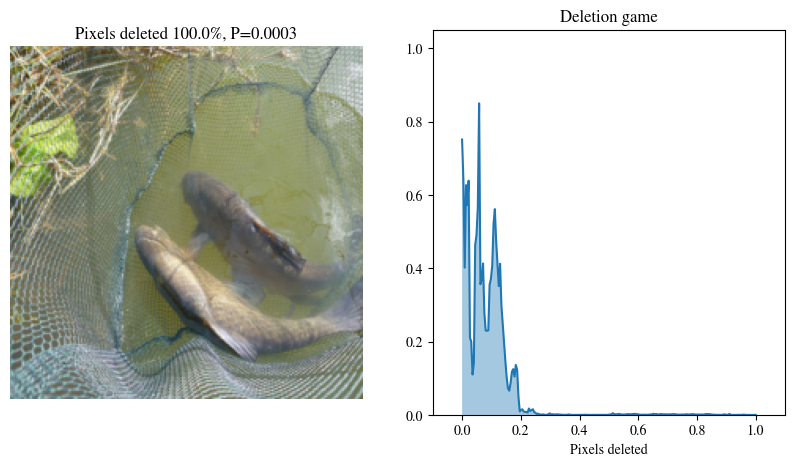

In [52]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

 99%|█████████▉| 223/225 [00:01<00:00, 147.54it/s]


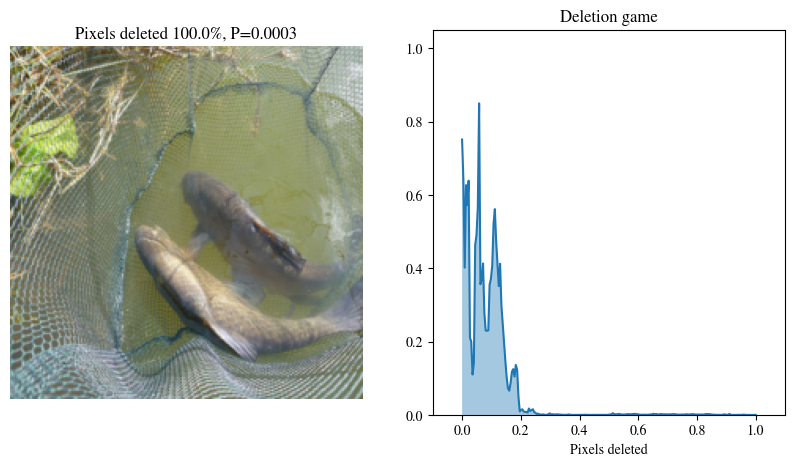

In [53]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

In [54]:
gdel_evaluator_archipelago = GroupedDeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gdel_score_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks)
print(gdel_score_archipelago)

tensor([0.0579], device='cuda:0')


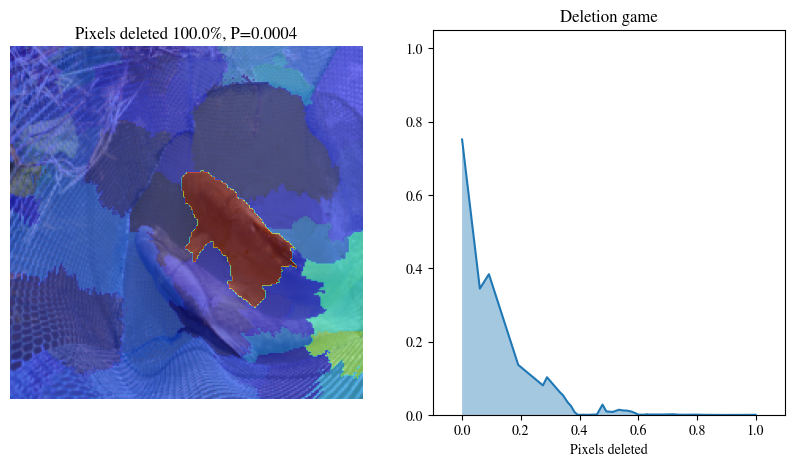

In [55]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])

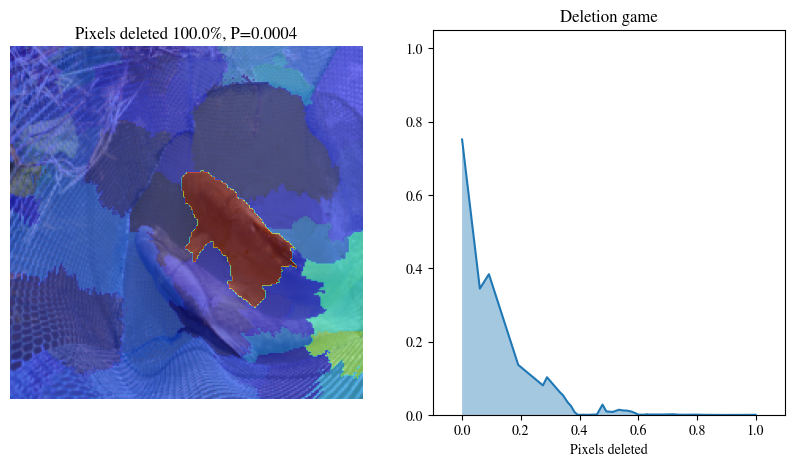

In [56]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])

In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from exlib.evaluators.common import Evaluator, convert_idx_masks_to_bool
from exlib.evaluators.ins_del import InsDelCls

class GroupedInsDelCls(InsDelCls):

    def __init__(self, model, mode='del', substrate_fn=torch.zeros_like, postprocess=None):
        """Create deletion/insertion metric instance.
        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        step = 1
        super(GroupedInsDelCls, self).__init__(model, mode, step, substrate_fn, postprocess)
    
    def auc(self, arr, step_sizes):
        """Returns normalized Area Under Curve of the array."""
        return ((arr[:, 1:] + arr[:, :-1] * step_sizes[1:]) / 2).sum() / step_sizes.sum()
        # return (arr.sum(-1) - arr[:, 0] / 2 - arr[:, -1] / 2) / (step_sizes)
        # return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)
        # return (arr.sum(-1).sum(-1) - arr[1] / 2 - arr[-1] / 2) / (arr.shape[1] - 1)
        # if len(arr.shape) == 2:
        return (arr.sum(-1) - arr[:, 0] / 2 - arr[:, -1] / 2) / (arr.shape[1] - 1)

    def forward(self, X, Z, group_mask=None, masks_all=None, masks_scores_all=None, kwargs={}, return_dict=False):
        """Run metric on one image-saliency pair.
            Args:
                X = img_tensor (Tensor): normalized image tensor. (bsz, n_channel, img_dim1, img_dim2)
                Z = explanation (Tensor): saliency map. (bsz, 1, img_dim1, img_dim2)
                sem_part: (bsz, 1, img_dim1, img_dim2)
                verbose (int): in [0, 1, 2].
                    0 - return list of scores.
                    1 - also plot final step.
                    2 - also plot every step and print 2 top classes.
                save_to (str): directory to save every step plots to.
            Return:
                scores (Tensor): Array containing scores at every step.
        """
        assert group_mask is not None or (masks_all is not None and masks_scores_all is not None)
        
        self.model.eval()
        auc_score_all = []
        scores_all = []
        starts = []
        finishes = []
        step_sizes_all = []
        for b_i in range(X.size(0)):
            if group_mask is not None:
                group_mask_bool = convert_idx_masks_to_bool(group_mask[b_i:b_i+1])
            else:
                group_mask_bool = masks_all[b_i:b_i+1]
                
            import pdb; pdb.set_trace()
            num_masks = group_mask_bool.size(0)

            img_tensor = X[b_i:b_i+1]
            explanation = Z[b_i:b_i+1].to(img_tensor.device)

            bsz, n_channel, img_dim1, img_dim2 = img_tensor.shape
            HW = img_dim1 * img_dim2
            kwargs_i = {k: v[b_i:b_i+1] for k, v in kwargs.items()}
            with torch.no_grad():
                pred = self.model(img_tensor, **kwargs_i)
                if self.postprocess is not None:
                    pred = self.postprocess(pred)
            top, c = torch.max(pred, 1)

            if self.mode == 'del':
                start = img_tensor.clone()
                finish = self.substrate_fn(img_tensor)
            elif self.mode == 'ins':
                start = self.substrate_fn(img_tensor)
                finish = img_tensor.clone()
            start_clone = start.clone()

            # start[start < -1] = -1.0
            # start[start > 1] = 1.0
            # finish[finish < -1] = 
            # finish[finish > 1] = 1.0
            import pdb; pdb.set_trace()
            if group_mask is not None:
                t_r_masks = (explanation * group_mask_bool.unsqueeze(1).float()).reshape(num_masks, 
                                                                                    -1).mean(-1)
            else:
                t_r_masks = masks_scores_all[b_i:b_i+1]
            salient_order_masks = torch.argsort(t_r_masks, dim=-1).flip(-1)

            n_steps = len(salient_order_masks)

            scores = torch.empty(bsz, n_steps + 1).cuda()
            step_sizes = [0]
            # Coordinates of pixels in order of decreasing saliency
            for i in range(n_steps+1):
                with torch.no_grad():
                    pred_mod = self.model(start, **kwargs_i)
                    if self.postprocess is not None:
                        pred_mod = self.postprocess(pred_mod)

                pred_mod = torch.softmax(pred_mod, dim=-1)
                scores[:,i] = pred_mod[range(bsz), c]
                
                if i < n_steps:
                    mask_sem_best = group_mask_bool[salient_order_masks[i]]
                    start[0,:,mask_sem_best] = finish[0,:,mask_sem_best]
                    step_sizes.append(mask_sem_best.sum().item())
                # import pdb; pdb.set_trace()

            # import pdb; pdb.set_trace()
            step_sizes = torch.tensor(step_sizes).to(scores.device)
            auc_score = self.auc(scores, step_sizes)
            
            auc_score_all.append(auc_score)
            scores_all.append(scores[0])
            starts.append(start_clone)
            finishes.append(finish)
            step_sizes_all.append(step_sizes)
        
        if return_dict:
            return {
                'auc_score': torch.stack(auc_score_all),
                'scores': scores_all,
                'start': torch.stack(starts),
                'finish': torch.stack(finishes),
                'step_sizes': step_sizes_all
            }
        else:
            return torch.stack(auc_score_all)
        
    def plot(self, img_tensor, explanation, scores, step_sizes, save_to=None):
        n_steps = scores.shape[-1] - 1
        i = n_steps
        step_sizes_cum_sum_frac = (step_sizes.cumsum(-1) / step_sizes.sum())
        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, 
                                                scores[i]))
        plt.axis('off')
        plt.imshow(img_tensor.cpu().numpy().transpose(1, 2, 0))
        plt.imshow(explanation.cpu().numpy().transpose(1, 2, 0), alpha=0.5, cmap='jet')

        plt.subplot(122)
        plt.plot(step_sizes_cum_sum_frac.cpu().numpy(), scores.cpu().numpy())
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1.05)
        plt.fill_between(step_sizes_cum_sum_frac.cpu().numpy(), 0, 
                         scores.cpu().numpy(), 
                         alpha=0.4)
        plt.title(title)
        plt.xlabel(ylabel)
        # plt.ylabel(get_class_name(c))
        if save_to:
            plt.savefig(save_to)
            plt.close()
        else:
            plt.show()


class GroupedDeletionCls(GroupedInsDelCls):

    def __init__(self, model, substrate_fn=torch.zeros_like, 
                 postprocess=None):
        mode = 'del'
        super(GroupedDeletionCls, self).__init__(model, mode, substrate_fn, postprocess)


class GroupedInsertionCls(GroupedInsDelCls):

    def __init__(self, model, substrate_fn=torch.zeros_like, 
                 postprocess=None):
        mode = 'ins'
        super(GroupedInsertionCls, self).__init__(model, mode, substrate_fn, postprocess)

/tmp/ipykernel_3483/1600554230.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [121]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from exlib.evaluators.common import Evaluator, convert_idx_masks_to_bool
from exlib.evaluators.ins_del import InsDelCls

class GroupedInsDelCls(InsDelCls):

    def __init__(self, model, mode='del', substrate_fn=torch.zeros_like, postprocess=None):
        """Create deletion/insertion metric instance.
        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        step = 1
        super(GroupedInsDelCls, self).__init__(model, mode, step, substrate_fn, postprocess)
    
    def auc(self, arr, step_sizes):
        """Returns normalized Area Under Curve of the array."""
        return ((arr[:, 1:] + arr[:, :-1] * step_sizes[1:]) / 2).sum() / step_sizes.sum()
        # return (arr.sum(-1) - arr[:, 0] / 2 - arr[:, -1] / 2) / (step_sizes)
        # return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)
        # return (arr.sum(-1).sum(-1) - arr[1] / 2 - arr[-1] / 2) / (arr.shape[1] - 1)
        # if len(arr.shape) == 2:
        return (arr.sum(-1) - arr[:, 0] / 2 - arr[:, -1] / 2) / (arr.shape[1] - 1)

    def forward(self, X, Z, masks_scores_all=None, kwargs={}, return_dict=False):
        """Run metric on one image-saliency pair.
            Args:
                X = img_tensor (Tensor): normalized image tensor. (bsz, n_channel, img_dim1, img_dim2)
                Z = masks, (list of Tensor): saliency map. bsz list of (num_masks, img_dim1, img_dim2)
                masks_scores_all: list of Tensor: bsz list of (num_masks)
                verbose (int): in [0, 1, 2].
                    0 - return list of scores.
                    1 - also plot final step.
                    2 - also plot every step and print 2 top classes.
                save_to (str): directory to save every step plots to.
            Return:
                scores (Tensor): Array containing scores at every step.
        """
        # assert group_mask is not None or (masks_all is not None and masks_scores_all is not None)
        
        self.model.eval()
        auc_score_all = []
        scores_all = []
        starts = []
        finishes = []
        step_sizes_all = []
        used_masks_all = []
        for b_i in range(X.size(0)):
            group_mask_bool = Z[b_i]
                
            # import pdb; pdb.set_trace()
            num_masks = group_mask_bool.size(0)

            img_tensor = X[b_i].unsqueeze(0)
            # explanation = Z[b_i:b_i+1].to(img_tensor.device)

            bsz, n_channel, img_dim1, img_dim2 = img_tensor.shape
            HW = img_dim1 * img_dim2
            kwargs_i = {k: v[b_i:b_i+1] for k, v in kwargs.items()}
            with torch.no_grad():
                pred = self.model(img_tensor, **kwargs_i)
                if self.postprocess is not None:
                    pred = self.postprocess(pred)
            top, c = torch.max(pred, 1)

            if self.mode == 'del':
                start = img_tensor.clone()
                finish = self.substrate_fn(img_tensor)
            elif self.mode == 'ins':
                start = self.substrate_fn(img_tensor)
                finish = img_tensor.clone()
            start_clone = start.clone()

            # start[start < -1] = -1.0
            # start[start > 1] = 1.0
            # finish[finish < -1] = 
            # finish[finish > 1] = 1.0
            # import pdb; pdb.set_trace()
            t_r_masks = masks_scores_all[b_i]
            salient_order_masks = torch.argsort(t_r_masks, dim=-1).flip(-1)

            n_steps = len(salient_order_masks)

            scores = torch.zeros(bsz, n_steps + 1).cuda()
            # scores = []
            step_sizes = [0]
            # Coordinates of pixels in order of decreasing saliency
            used_masks = torch.zeros(img_dim1, img_dim2).to(X.device)
            for i in tqdm(range(n_steps)):
                # if i < n_steps:
                mask_best = group_mask_bool[salient_order_masks[i]]
                mask_best_new = (mask_best - (used_masks > 0).int()) == 1
                new_count = mask_best_new.sum().item()
                # if nothing is added, then skip to next iteration
                step_sizes.append(new_count)
                if new_count == 0:
                    continue

                with torch.no_grad():
                    pred_mod = self.model(start, **kwargs_i)
                    if self.postprocess is not None:
                        pred_mod = self.postprocess(pred_mod)

                pred_mod = torch.softmax(pred_mod, dim=-1)
                scores[:,i] = pred_mod[range(bsz), c]
                # scores.append(pred_mod[range(bsz), c])

                # import pdb; pdb.set_trace()
                start[0,:,mask_best_new] = finish[0,:,mask_best_new]
                
                used_masks = used_masks + mask_best_new * (i + 1) #len(step_sizes)
                # import pdb; pdb.set_trace()

            # import pdb; pdb.set_trace()
            step_sizes = torch.tensor(step_sizes).to(scores.device)
            # import pdb; pdb.set_trace()
            auc_score = self.auc(scores, step_sizes)
            
            auc_score_all.append(auc_score)
            scores_all.append(scores[0])
            starts.append(start_clone)
            finishes.append(finish)
            step_sizes_all.append(step_sizes)
            used_masks_all.append(used_masks)
        
        if return_dict:
            return {
                'auc_score': torch.stack(auc_score_all),
                'scores': scores_all,
                'start': torch.stack(starts),
                'finish': torch.stack(finishes),
                'step_sizes': step_sizes_all,
                'used_masks': torch.stack(used_masks_all)
            }
        else:
            return torch.stack(auc_score_all)
        
    def plot(self, img_tensor, explanation, scores, step_sizes, save_to=None):
        n_steps = scores.shape[-1] - 1
        i = n_steps
        step_sizes_cum_sum_frac = (step_sizes.cumsum(-1) / step_sizes.sum())
        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, 
                                                scores[i]))
        plt.axis('off')
        plt.imshow(img_tensor.cpu().numpy().transpose(1, 2, 0))
        plt.imshow(1 - explanation.cpu().numpy(), alpha=0.5, cmap='hot')
        # plt.imshow(explanation.cpu().numpy().transpose(1, 2, 0), alpha=0.5, cmap='jet')

        plt.subplot(122)
        plt.plot(step_sizes_cum_sum_frac.cpu().numpy(), scores.cpu().numpy())
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1.05)
        plt.fill_between(step_sizes_cum_sum_frac.cpu().numpy(), 0, 
                         scores.cpu().numpy(), 
                         alpha=0.4)
        plt.title(title)
        plt.xlabel(ylabel)
        # plt.ylabel(get_class_name(c))
        if save_to:
            plt.savefig(save_to)
            plt.close()
        else:
            plt.show()


class GroupedDeletionCls(GroupedInsDelCls):

    def __init__(self, model, substrate_fn=torch.zeros_like, 
                 postprocess=None):
        mode = 'del'
        super(GroupedDeletionCls, self).__init__(model, mode, substrate_fn, postprocess)


class GroupedInsertionCls(GroupedInsDelCls):

    def __init__(self, model, substrate_fn=torch.zeros_like, 
                 postprocess=None):
        mode = 'ins'
        super(GroupedInsertionCls, self).__init__(model, mode, substrate_fn, postprocess)

/tmp/ipykernel_4227/2736441864.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [115]:
expln._fields, expln.masks.shape, expln.mask_weights.shape, expln.logits.shape, expln.logits_all.shape

(('logits',
  'logits_all',
  'pooler_outputs_all',
  'masks',
  'mask_weights',
  'attributions',
  'attributions_max',
  'attributions_all',
  'flat_masks',
  'grouped_attributions'),
 torch.Size([1, 392, 224, 224]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10]),
 torch.Size([1, 392, 10]))

In [89]:
pred = expln.logits.argmax(-1)
pred

tensor([0], device='cuda:0')

In [116]:
i = 0
pred_mask_idxs_sort = expln.mask_weights[i,:,pred[i]].argsort(descending=True)
mask_weights_sort = (expln.mask_weights * expln.logits_all)[i,pred_mask_idxs_sort,pred[i]]
masks_sort = expln.masks[i,pred_mask_idxs_sort]
print(mask_weights_sort.shape, masks_sort.shape)

torch.Size([392]) torch.Size([392, 224, 224])


In [127]:
masks_sort_used = (masks_sort[mask_weights_sort > 0] > 0.5).int()
# masks_sort_used = (masks_sort[mask_weights_sort > 0] > 0).int()
mask_weights_sort_used = mask_weights_sort[mask_weights_sort > 0]
print(mask_weights_sort_used.shape, masks_sort_used.shape)

torch.Size([21]) torch.Size([21, 224, 224])


In [131]:
masks_sort[mask_weights_sort > 0].max(), masks_sort[mask_weights_sort > 0].min()

(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))

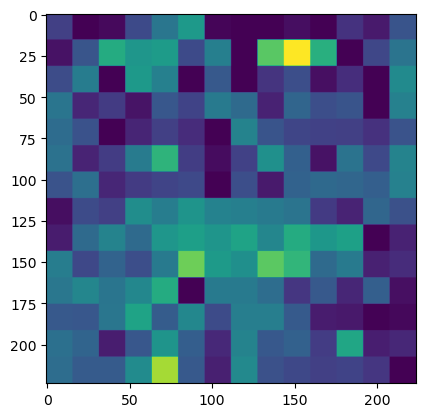

In [125]:
plt.imshow(masks_sort[mask_weights_sort > 0] [0].cpu().numpy())

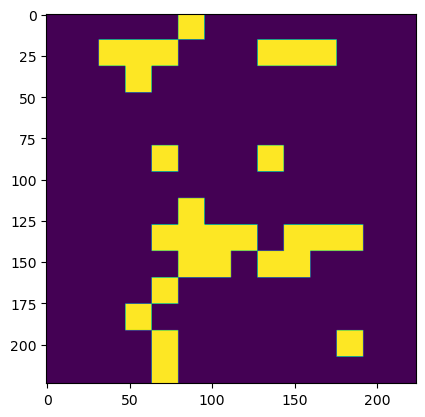

In [126]:
plt.imshow((masks_sort[mask_weights_sort > 0][0] > 0.5).cpu().numpy())

100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


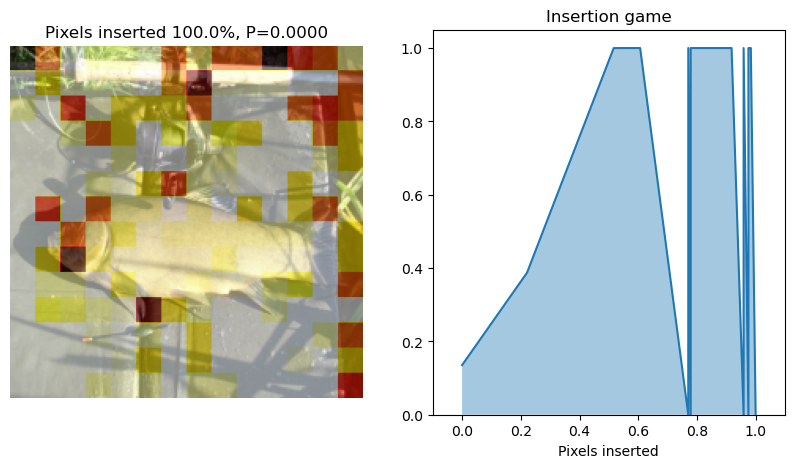

tensor([0.3141], device='cuda:0')

In [128]:
gins_evaluator = GroupedInsertionCls(model)
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, [masks_sort_used], masks_scores_all=[mask_weights_sort_used], return_dict=True)
gins_evaluator.plot(denormed_img[0], gins_eval_output['used_masks'][0], 
                    gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])
gins_eval_output['auc_score']

In [129]:
# masks_sort_used = (masks_sort[mask_weights_sort > 0] > 0.5).int()
masks_sort_used = (masks_sort[mask_weights_sort > 0] > 0).int()
mask_weights_sort_used = mask_weights_sort[mask_weights_sort > 0]
print(mask_weights_sort_used.shape, masks_sort_used.shape)

torch.Size([21]) torch.Size([21, 224, 224])


100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


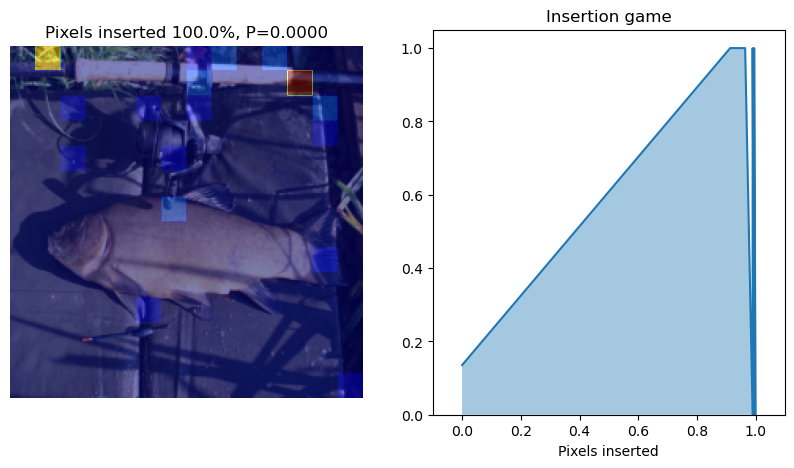

tensor([0.1052], device='cuda:0')

In [96]:
gins_evaluator = GroupedInsertionCls(model)
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, [masks_sort_used], masks_scores_all=[mask_weights_sort_used], return_dict=True)
gins_evaluator.plot(denormed_img[0], gins_eval_output['used_masks'][0], 
                    gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])
gins_eval_output['auc_score']

100%|██████████| 33/33 [00:21<00:00,  1.56it/s]


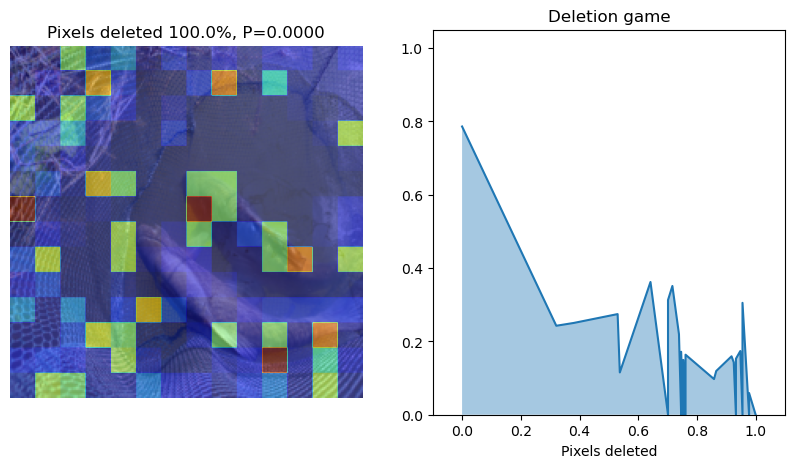

tensor([0.1967], device='cuda:0')

In [82]:
gdel_evaluator = GroupedDeletionCls(model)
with torch.no_grad():
    gdel_eval_output = gdel_evaluator(inputs, [masks_sort_used], masks_scores_all=[mask_weights_sort_used], return_dict=True)
gdel_evaluator.plot(denormed_img[0], gdel_eval_output['used_masks'][0], 
                    gdel_eval_output['scores'][0], gdel_eval_output['step_sizes'][0])
gdel_eval_output['auc_score']

{'auc_score': tensor([0.3797], device='cuda:0'),
 'scores': [tensor([0.7861, 0.2442, 0.0879, 0.0000, 0.0000, 0.2149, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         device='cuda:0')],
 'start': tensor([[[[[-0.0353,  0.0745,  0.2941,  ...,  0.4275,  0.5608,  0.4902],
            [-0.2000,  0.4039,  0.5059,  ...,  0.3725,  0.5373,  0.5059],
            [ 0.4353,  0.0667,  0.3176,  ...,  0.2471,  0.2863,  0.2157],
            ...,
            [ 0.0510, -0.0588, -0.0510,  ...,  0.2706,  0.0902, -0.1216],
            [-0.1529, -0.1608, -0.0980,  ...,  0.1922, -0.0824, -0.1843],
            [-0.2627, -0.2627, -0.1373,  ..., -0.0353, -0.1843, -0.2314]],
 
           [[ 0.0431,  0.0510,  0.3098,  ...,  0.4745,  0.6314,  0.5765],
            [-0.1765,  0.4353,  0.6235,  ...,  0.4196

In [39]:
expln._fields

('logits',
 'logits_all',
 'pooler_outputs_all',
 'masks',
 'mask_weights',
 'attributions',
 'attributions_max',
 'attributions_all',
 'flat_masks',
 'grouped_attributions')

In [40]:
pred = torch.argmax(expln.logits, dim=-1)
pred

tensor([0], device='cuda:0')

In [41]:
(expln.mask_weights[:,:,pred] > 0).shape

torch.Size([1, 392, 1])

In [42]:
expln.masks.shape

torch.Size([1, 392, 224, 224])

In [43]:
expln.mask_weights[:,:,pred][expln.mask_weights[:,:,pred] > 0].shape

torch.Size([33])

In [44]:
expln.masks[expln.mask_weights[:,:,pred][expln.mask_weights[:,:,pred] > 0]]

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [25]:
expln.masks.shape, expln.mask_weights.shape, expln.logits.shape

(torch.Size([1, 392, 224, 224]),
 torch.Size([1, 392, 1000]),
 torch.Size([1, 1000]))

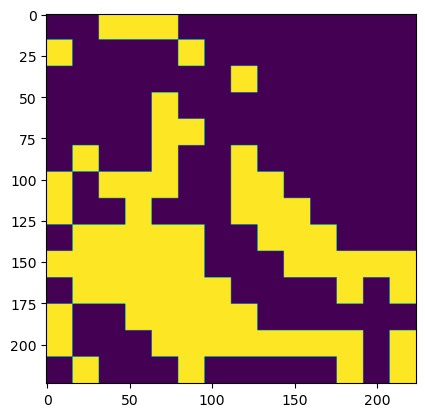

In [45]:
plt.imshow(expln.flat_masks.cpu()[0])

In [39]:
expln.flat_masks

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.int32)

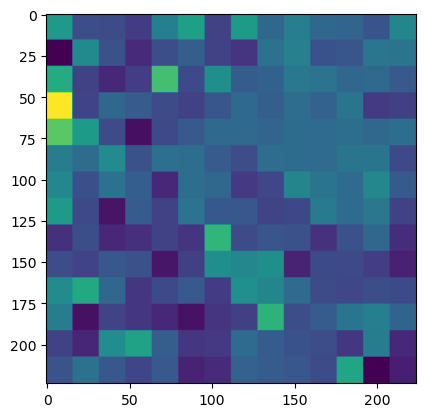

In [42]:
plt.imshow(expln.masks[0][0].cpu())

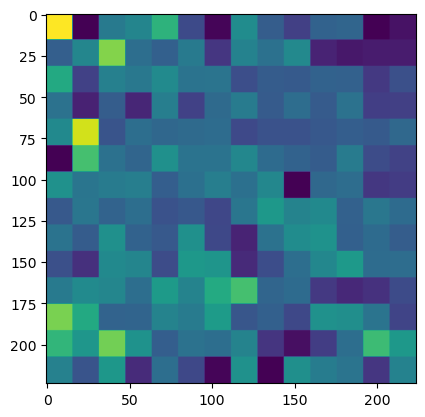

In [43]:
plt.imshow(expln.masks[0][1].cpu())